In [1]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import LineString,Point, Polygon, shape
from shapely.ops import unary_union
import geopandas as gpd
import pandas as pd
import io
from PIL import Image
import requests
from io import BytesIO
import os
import pickle
from tqdm import tqdm
import dpkt
# from Utils import get_foreground_point_cloud


from LiDARBase import parse_one_packet,calc_precise_azimuth,laser_id,Data_order,arg_omega,calc_timing_offsets,get_foreground_point_cloud
from Utils import *
from GenBckFile import *
# use sobel filter to get horizontal gradient
from scipy import ndimage
from scipy.signal import convolve2d
from DDBSCAN import *


pygame 2.5.2 (SDL 2.28.3, Python 3.8.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# unix time to utc time to pacific time
def unix2utc(unix_time):
    return pd.to_datetime(unix_time,unit='s').tz_localize('UTC').tz_convert('US/Pacific')
def load_pcap(file_path):
    try:
        fpcap = open(file_path, 'rb')
        eth_reader = dpkt.pcap.Reader(fpcap)
    except Exception as ex:
        print(str(ex))
        return None
    return eth_reader
    
def read_packets_offline(pcap_file_path):
    eth_reader = load_pcap(pcap_file_path)
    while True:
        # Simulate reading a packet from the Ethernet
        try:
            ts,buf = next(eth_reader)
        except StopIteration:
            return None
        eth = dpkt.ethernet.Ethernet(buf)
        if eth.type == 2048: # for ipv4
            if (type(eth.data.data) == dpkt.udp.UDP):# for ipv4
                data = eth.data.data.data
                packet_status = eth.data.data.sport
                if packet_status == 2368:
                    if len(data) != 1206:
                        continue
            # raw_packet = np.random.rand(20000,2) * 600  # Placeholder for actual packet data
                    yield (ts,data)
                    
def parse_packets(packet_gen):
    
    culmulative_azimuth_values = []
    culmulative_laser_ids = []
    culmulative_distances = []
    # culmulative_intensities = []
    Td_map = np.zeros((32,1800))
    # Intens_map = np.zeros((32,1800))
    next_ts = 0
    packet = next(packet_gen)
    if packet is None:
        return None
    ts,raw_packet = packet
    distances,intensities,azimuth_per_block,Timestamp = parse_one_packet(raw_packet)
    next_ts = ts + 0.1 # 0.1sec
    azimuth = calc_precise_azimuth(azimuth_per_block) # 32 x 12
    culmulative_azimuth_values.append(azimuth)
    culmulative_laser_ids.append(laser_id)
    culmulative_distances.append(distances)
            
    break_flag = False
    while True:
        if break_flag:
            break  
        while True:
            try:
                packet = next(packet_gen)
            except StopIteration:
                break_flag = True
                break
            ts,raw_packet = packet
            # Placeholder for parsing logic; here we just pass the data through
            distances,intensities,azimuth_per_block,Timestamp = parse_one_packet(raw_packet)
            # flag = self.if_rollover(azimuth_per_block,Initial_azimuth)
            azimuth = calc_precise_azimuth(azimuth_per_block) # 32 x 12
            
            if ts > next_ts:
                
                if len(culmulative_azimuth_values) > 0:
                    
                    culmulative_azimuth_values = np.concatenate(culmulative_azimuth_values,axis = 1)
                    culmulative_azimuth_values += Data_order[:,1].reshape(-1,1)
                    culmulative_laser_ids = np.concatenate(culmulative_laser_ids,axis = 1).flatten()
                    culmulative_distances = np.concatenate(culmulative_distances,axis = 1).flatten()
                    # culmulative_intensities = np.concatenate(culmulative_intensities,axis = 1).flatten()
                    culmulative_azimuth_inds = np.around(culmulative_azimuth_values/0.2).astype('int').flatten()
                    culmulative_azimuth_inds[(culmulative_azimuth_inds<0)|(culmulative_azimuth_inds>1799)] = culmulative_azimuth_inds[(culmulative_azimuth_inds<0)|(culmulative_azimuth_inds>1799)]%1799

                    Td_map[culmulative_laser_ids,culmulative_azimuth_inds] = culmulative_distances
                    # Intens_map[culmulative_laser_ids,culmulative_azimuth_inds] = culmulative_intensities
                    
                    yield Td_map[arg_omega,:] #32*1800
                else:
                    yield Td_map,ts #32*1800

                culmulative_azimuth_values = []
                culmulative_laser_ids = []
                culmulative_distances = []
                # culmulative_intensities = []

                Td_map = np.zeros((32,1800))
                # Intens_map = np.zeros((32,1800))
                next_ts += 0.1
                break
            else:
                culmulative_azimuth_values.append(azimuth)
                culmulative_laser_ids.append(laser_id)
                culmulative_distances.append(distances)
                # culmulative_intensities.append(intensities)
    return None

In [3]:
Td_maps = []
pcap_file_path = r'D:\LiDAR_Data\9thVir\2024-03-14-23-30-00.pcap'
packets_gen = read_packets_offline(pcap_file_path)
packet = next(packets_gen)
Initial_ts,raw_packet = packet

packets_gen = read_packets_offline(pcap_file_path)
td_gen = parse_packets(packets_gen)
for Td_map in tqdm(td_gen):
    Td_maps.append(Td_map)

0it [00:00, ?it/s]

103it [00:03, 32.86it/s]


KeyboardInterrupt: 

In [10]:
type(Td_maps[0])

numpy.ndarray

In [8]:

background_data = np.array(Td_maps)

C:\Users\zhChe\AppData\Local\Temp\ipykernel_17712\1170685292.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  background_data = np.array(Td_maps)


In [6]:

background_data = np.array(Td_maps)
thred_map = gen_bckmap(np.array(background_data), N = 10,d_thred = 0.1,bck_n = 3)         

C:\Users\zhChe\AppData\Local\Temp\ipykernel_17712\403226323.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  background_data = np.array(Td_maps)
  0%|          | 0/32 [00:00<?, ?it/s]


IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

In [ ]:
np.save('./thred_map.npy',thred_map)
thred_map = np.load('./thred_map.npy')

In [5]:
bck_radius = 0.3
vertical_limits = [0,31]
lane_drawer = LaneDrawer() # lane drawer for queue detection
lane_drawer.update_lane_gdf()

Lane zone updated


In [8]:
count_thred = 3
time_space_series = [] # t x laen# x lane_section#
for Td_map in tqdm(Td_maps):
    
    data_raw,point_labels,tracking_dic = get_foreground_point_cloud(thred_map,bck_radius,
                                                                            Td_map,vertical_limits)
    if len(data_raw) == 0:
        break
    lane_section_foreground_point_counts = get_lane_section_foreground_point_counts(lane_drawer.lane_subsections_poly,
                                                                                lane_drawer.lane_gdf,
                                                                                data_raw,point_labels)
    activation_profile = []
    for lane_counts in lane_section_foreground_point_counts:
        occupation = np.array(lane_counts) > count_thred
        activation_profile.append(occupation)
    time_space_series.append(activation_profile)
# test_time_space_series = np.array(test_time_space_series)

 56%|█████▋    | 10125/17989 [15:11<11:48, 11.11it/s]


KeyboardInterrupt: 

In [11]:
lane_ind = 0
lane_activation_profile = []
for t in range(len(time_space_series)):
    lane_activation_cur = time_space_series[t][lane_ind]
    lane_activation_profile.append(lane_activation_cur)
lane_activation_profile = np.array(lane_activation_profile,dtype=int)
lane_activation_profile_T = lane_activation_profile.T

In [12]:
lane_activation_profile_T = lane_activation_profile.T
stop_specturm = ndimage.sobel(lane_activation_profile_T, 0)  # horizontal gradient
# travel_specturm = ndimage.sobel(lane_activation_profile_T, 1)  # horizontal gradient
empty_specturm = np.zeros(lane_activation_profile_T.shape,dtype=np.uint8)
lines = cv2.HoughLinesP(image= (stop_specturm > 0).astype(np.uint8),rho=1,theta=np.pi/2,threshold=50,minLineLength=50,maxLineGap=5)
for line in lines:
    x1,y1,x2,y2 = line[0]
    cv2.line(empty_specturm,(x1,y1),(x2,y2),(1,0,0),2)

In [13]:
queue_length_indicator = empty_specturm != 0

total_queue_length_curve = []
for i in range(0,queue_length_indicator.shape[1],1):
    stops = np.where(queue_length_indicator[:,i])[0]
    if len(stops) == 0:
        total_queue_length_curve.append(0)
        continue
    queue_length_t = (queue_length_indicator.shape[0] - stops.min()) * 0.5
    total_queue_length_curve.append(queue_length_t)
total_queue_length_curve = np.array(total_queue_length_curve)
# sample at 10 frames
total_queue_length_curve_sec = total_queue_length_curve[::10]

In [16]:
# find the start and end of each consecutive activation event
def find_concecutive_activation(activation):
    activation_start = []
    activation_end = []
    activation_flag = False
    for i in range(len(activation)):

        if activation[i] == True and activation_flag == False:
            activation_start.append(i)
            activation_flag = True
        elif activation[i] == False and activation_flag == True:
            activation_end.append(i)
            activation_flag = False
    return activation_start,activation_end

In [18]:
# define a kernal to identify a sudden change toward upper direction
import statistics
kernal = np.array([0] * 10 + [1] * 5)
volumes = []
for i in range(1,10):
    activation = lane_activation_profile_T[-i,:]
    # convolve the kernal with the lane_activation_profile_T
    convolution = np.convolve(activation,kernal,mode='same')
    passing_incator = convolution > 0
    activation_start,activation_end = find_concecutive_activation(passing_incator)
    # activation_end = np.array(activation_end)
    activation_start = np.array(activation_start)
    volume_section = []
    for ts in range(10,lane_activation_profile_T.shape[1] + 10,10):
        volume_section.append(((activation_start < ts)&(activation_start > ts - 10)).sum())
    volumes.append(volume_section)
volumes = np.array(volumes)
volumes_sec = []
for i in range(volumes.shape[1]):
    volumes_sec.append(statistics.mode(volumes[:,i]))
volumes_sec = np.array(volumes_sec)
    

In [28]:
out_folder = '.\output\\2024-03-14-23-30-00\\'
fig_folder = os.path.join(out_folder,'figures')
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

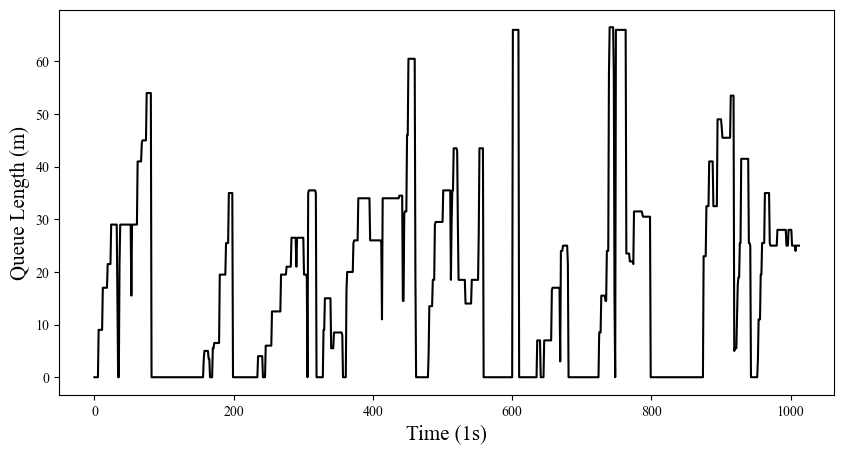

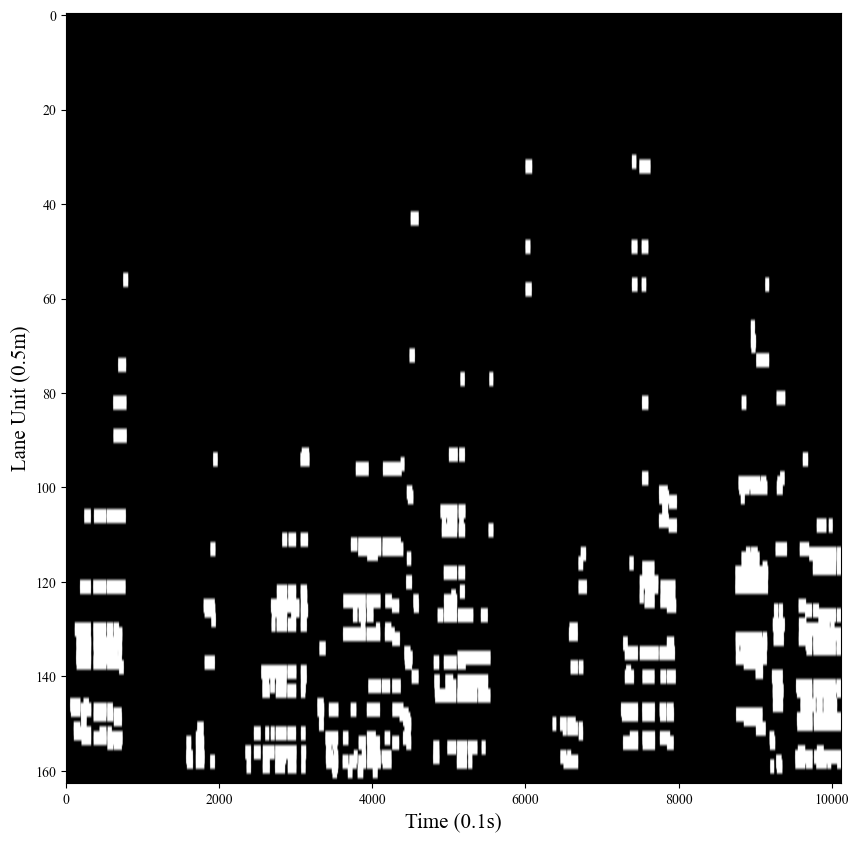

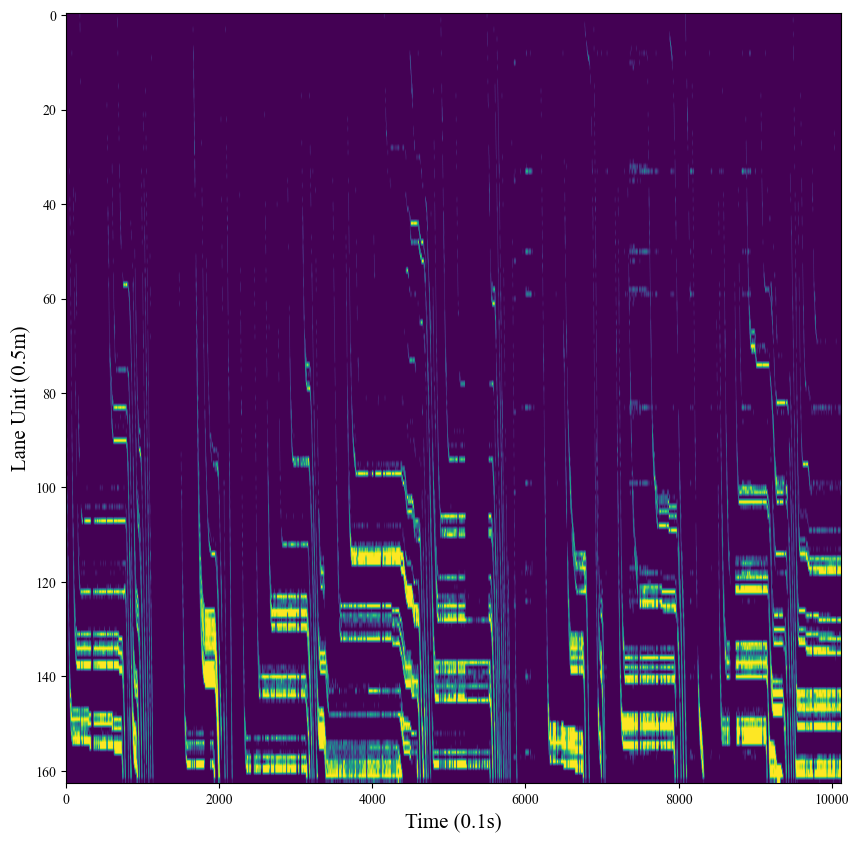

In [30]:
plt.rcParams['font.family'] = 'times new roman'
cum_volumes = []
for i in range(1,volumes_sec.shape[0]):
    cum_volumes.append(volumes_sec[:i].sum())
cum_volumes = np.array(cum_volumes)
plt.figure(figsize = (10,5))
plt.grid()
plt.plot(cum_volumes, linewidth = 2, color = 'black')
plt.xlabel('Time (1s)',fontsize = 15)
plt.ylabel('Volume (veh)',fontsize = 15)
plt.savefig(os.path.join(fig_folder,f'volume_{lane_ind}.png'),dpi = 300)
plt.close()
plt.figure(figsize = (10,5))
plt.plot(total_queue_length_curve_sec, color = 'black')
plt.xlabel('Time (1s)',fontsize = 15)
plt.ylabel('Queue Length (m)',fontsize = 15)
plt.savefig(os.path.join(fig_folder,f'queue_{lane_ind}.png'),dpi = 300)
plt.figure(figsize = (10,10))
# increase distincness of the image
plt.imshow(empty_specturm,aspect = 'auto',cmap='gray',interpolation = None)
# plt.imshow(sobel_v,aspect = 'auto',cmap='gray',interpolation = None)
plt.xlabel('Time (0.1s)',fontsize = 15)
plt.ylabel('Lane Unit (0.5m)',fontsize = 15)
# plt.xlim(14000,15500)# plt.ylim(0,32)
plt.savefig(os.path.join(fig_folder,f'queue_spectrum_{lane_ind}.png'),dpi = 300)
plt.figure(figsize = (10,10))
plt.imshow(lane_activation_profile_T,aspect = 'auto',interpolation = None)
plt.xlabel('Time (0.1s)',fontsize = 15)
plt.ylabel('Lane Unit (0.5m)',fontsize = 15)
# plt.xlim(12000,15500)
plt.savefig(os.path.join(fig_folder,f'time_space_{lane_ind}.png'),dpi = 300)

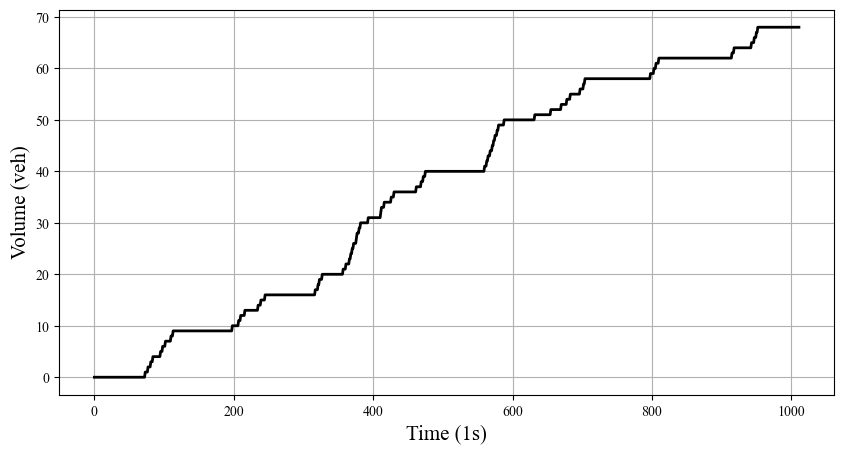

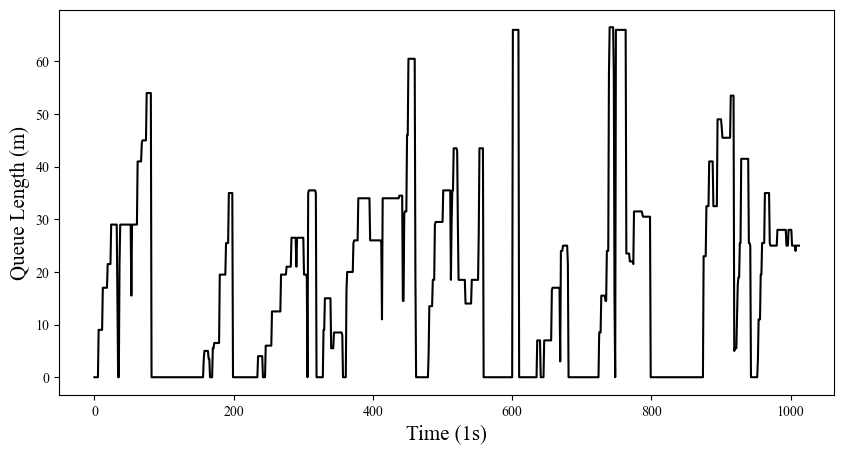

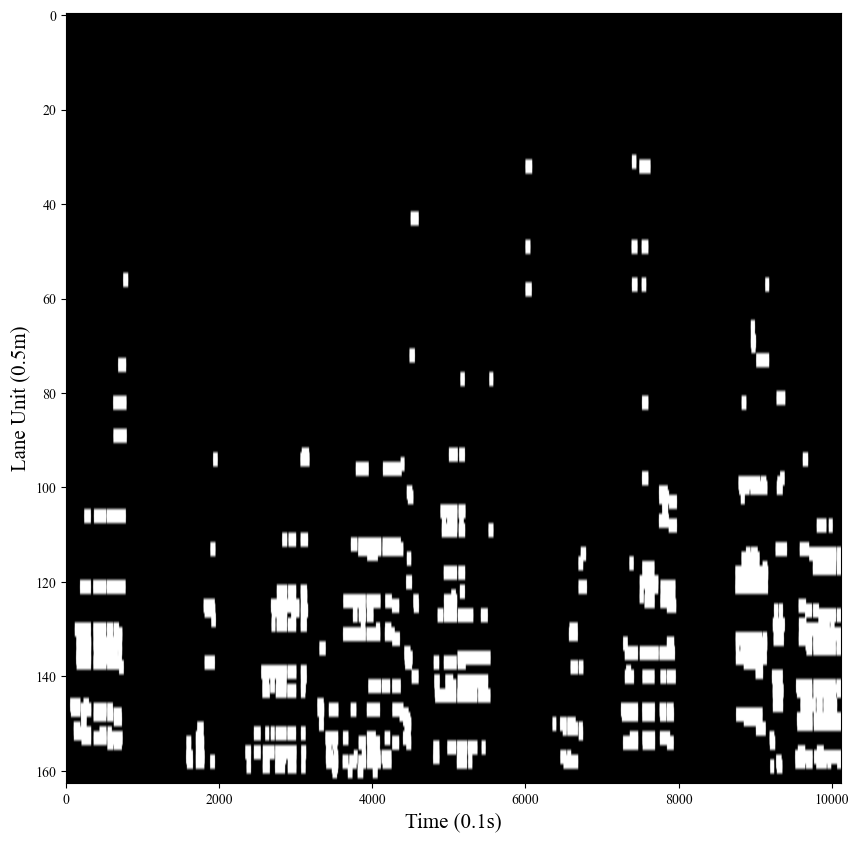

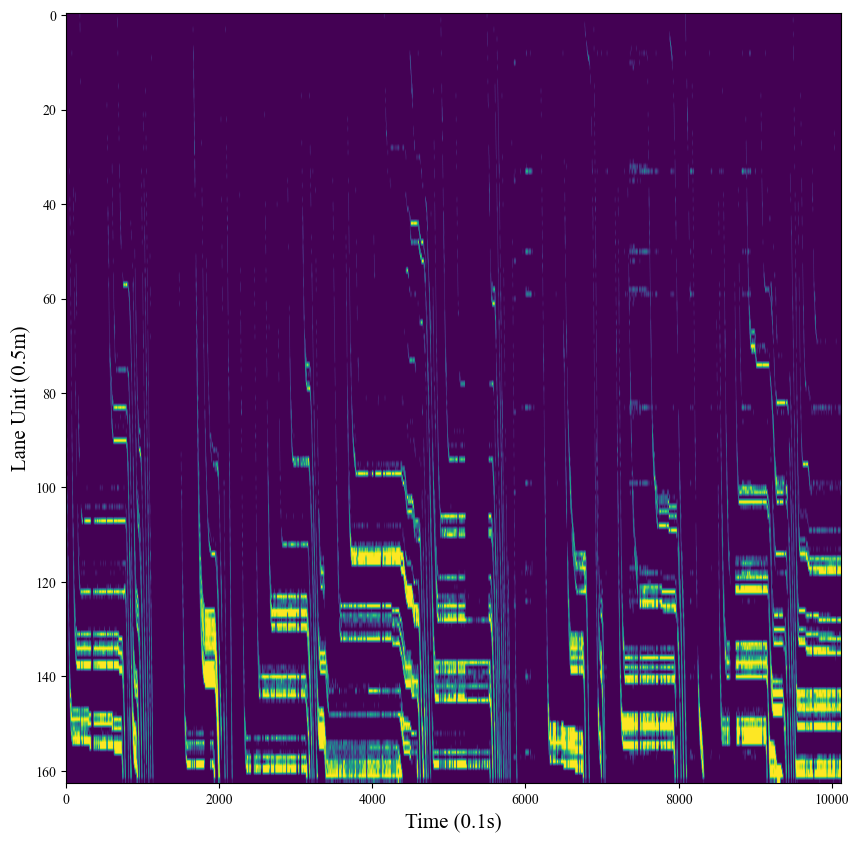

In [19]:
# plot the "cummulative" (sum up the volumes of all previous num) volume curve_sec
# times new roman
plt.rcParams['font.family'] = 'times new roman'
cum_volumes = []
for i in range(1,volumes_sec.shape[0]):
    cum_volumes.append(volumes_sec[:i].sum())
cum_volumes = np.array(cum_volumes)
plt.figure(figsize = (10,5))
plt.grid()
plt.plot(cum_volumes, linewidth = 2, color = 'black')
plt.xlabel('Time (1s)',fontsize = 15)
plt.ylabel('Volume (veh)',fontsize = 15)
plt.show()

plt.figure(figsize = (10,5))

plt.plot(total_queue_length_curve_sec, color = 'black')
plt.xlabel('Time (1s)',fontsize = 15)
plt.ylabel('Queue Length (m)',fontsize = 15)
plt.show()
plt.figure(figsize = (10,10))
# increase distincness of the image
plt.imshow(empty_specturm,aspect = 'auto',cmap='gray',interpolation = None)
# plt.imshow(sobel_v,aspect = 'auto',cmap='gray',interpolation = None)
plt.xlabel('Time (0.1s)',fontsize = 15)
plt.ylabel('Lane Unit (0.5m)',fontsize = 15)
# plt.xlim(14000,15500)# plt.ylim(0,32)
plt.show()
plt.figure(figsize = (10,10))
plt.imshow(lane_activation_profile_T,aspect = 'auto',interpolation = None)
plt.xlabel('Time (0.1s)',fontsize = 15)
plt.ylabel('Lane Unit (0.5m)',fontsize = 15)
# plt.xlim(12000,15500)
plt.show()

## Summary 

In [516]:
count_thred = 3 # activation point cloud # threshold
bck_radius = 0.2
vertical_limits = [0,31]
lane_drawer = LaneDrawer() # lane drawer for queue detection
lane_drawer.update_lane_gdf()


def main(pcap_file_path,lane_drawer,out_path):
    
    # extract the pcap_file name of the pcap_file_path and exclude the .pcap extension
    pcap_file_name = os.path.basename(pcap_file_path).split('.')[0]
    # create a folder to store the output by the pcap_file name and out_path
    out_folder = os.path.join(out_path,pcap_file_name)
    if not os.path.exists(out_folder):
        os.makedirs(out_folder)
    # create a folder in out_folder to store the figures
    fig_folder = os.path.join(out_folder,'figures')
     
    Td_maps = []
    packets_gen = read_packets_offline(pcap_file_path)
    packet = next(packets_gen)
    Initial_ts,raw_packet = packet
    # unix time to utc time to pacific time
    Initial_date = unix2utc(Initial_ts)
    packets_gen = read_packets_offline(pcap_file_path)
    td_gen = parse_packets(packets_gen)
    for Td_map in tqdm(td_gen):
        Td_maps.append(Td_map)
    
    background_data = np.array(Td_maps)
    thred_map = gen_bckmap(np.array(background_data), N = 10,d_thred = 0.1,bck_n = 3)
    # save thred_map as .npy file in out_folder
    np.save(os.path.join(out_folder,'thred_map.npy'),thred_map)
    
    time_space_series = [] # t x laen# x lane_section#
    for Td_map in tqdm(Td_maps):
        data_raw,point_labels,tracking_dic = get_foreground_point_cloud(thred_map,bck_radius,
                                                                                Td_map,vertical_limits)
        if len(data_raw) == 0:
            time_space_series.append(None)
            continue
        lane_section_foreground_point_counts = get_lane_section_foreground_point_counts(lane_drawer.lane_subsections_poly,
                                                                                    lane_drawer.lane_gdf,
                                                                                    data_raw,point_labels)
        activation_profile = []
        for lane_counts in lane_section_foreground_point_counts:
            occupation = np.array(lane_counts) > count_thred
            activation_profile.append(occupation)
        time_space_series.append(activation_profile)
    time_space_series = np.array(time_space_series)


    for lane_ind in range(len(lane_drawer.lane_subsections_poly)):
        lane_activation_profile = []
        for t in range(len(time_space_series)):
            lane_activation_cur = time_space_series[t][lane_ind]
            lane_activation_profile.append(lane_activation_cur)
        lane_activation_profile = np.array(lane_activation_profile,dtype=int)
        lane_activation_profile_T = lane_activation_profile.T
        stop_specturm = ndimage.sobel(lane_activation_profile_T, 0)  # horizontal gradient
        empty_specturm = np.zeros(lane_activation_profile_T.shape,dtype=np.uint8)
        lines = cv2.HoughLinesP(image= (stop_specturm > 0).astype(np.uint8),rho=1,theta=np.pi/2,threshold=100,minLineLength=50,maxLineGap=5)
        for line in lines:
            x1,y1,x2,y2 = line[0]
            cv2.line(empty_specturm,(x1,y1),(x2,y2),(1,0,0),2)
                     
        queue_length_indicator = empty_specturm != 0
        total_queue_length_curve = []
        for i in range(0,queue_length_indicator.shape[1],1):
            stops = np.where(queue_length_indicator[:,i])[0]
            if len(stops) == 0:
                total_queue_length_curve.append(0)
                continue
            queue_length_t = (queue_length_indicator.shape[0] - stops.min()) * 0.5
            total_queue_length_curve.append(queue_length_t)
        total_queue_length_curve = np.array(total_queue_length_curve)
        # sample at 10 frames
        total_queue_length_curve_sec = total_queue_length_curve[::10]

        # define a kernal to identify a sudden change toward upper direction
        kernel = np.array([0] * 10 + [1] * 5)
        volumes = []
        for i in range(1,10):
            activation = lane_activation_profile_T[-i,:]
            # convolve the kernal with the lane_activation_profile_T
            convolution = np.convolve(activation,kernel,mode='same')
            passing_incator = convolution > 0
            activation_start,activation_end = find_concecutive_activation(passing_incator)
            # activation_end = np.array(activation_end)
            activation_start = np.array(activation_start)
            volume_section = []
            for ts in range(10,lane_activation_profile_T.shape[1],10):
                volume_section.append(((activation_start < ts)&(activation_start > ts - 10)).sum())
            volumes.append(volume_section)
        volumes = np.array(volumes)
        volumes_sec = []
        for i in range(volumes.shape[1]):
            volumes_sec.append(statistics.mode(volumes[:,i]))
        volumes_sec = np.array(volumes_sec)
        # save queue curve and volumes_sec as one dataframe and save to out_folder, and named by queue_volume_{lane_ind}.csv
        # use init_date to create the time index at second level
        time_index = pd.date_range(Initial_date, periods = len(total_queue_length_curve_sec), freq = '1S')
        queue_volume_df = pd.DataFrame({'queue_length':total_queue_length_curve_sec,'volume':volumes_sec},index = time_index)
        queue_volume_df.to_csv(os.path.join(out_folder,f'queue_volume_{lane_ind}.csv'))
        
        # times new roman
        plt.rcParams['font.family'] = 'times new roman'
        cum_volumes = []
        for i in range(1,volumes_sec.shape[0]):
            cum_volumes.append(volumes_sec[:i].sum())
        cum_volumes = np.array(cum_volumes)
        plt.figure(figsize = (10,5))
        plt.grid()
        plt.plot(cum_volumes, linewidth = 2, color = 'black')
        plt.xlabel('Time (1s)',fontsize = 15)
        plt.ylabel('Volume (veh)',fontsize = 15)
        plt.savefig(os.path.join(fig_folder,f'volume_{lane_ind}.png'),dpi = 300)

        plt.figure(figsize = (10,5))

        plt.plot(total_queue_length_curve_sec, color = 'black')
        plt.xlabel('Time (1s)',fontsize = 15)
        plt.ylabel('Queue Length (m)',fontsize = 15)
        plt.savefig(os.path.join(fig_folder,f'queue_{lane_ind}.png'),dpi = 300)
        plt.figure(figsize = (10,10))
        # increase distincness of the image
        plt.imshow(empty_specturm,aspect = 'auto',cmap='gray',interpolation = None)
        # plt.imshow(sobel_v,aspect = 'auto',cmap='gray',interpolation = None)
        plt.xlabel('Time (0.1s)',fontsize = 15)
        plt.ylabel('Lane Unit (0.5m)',fontsize = 15)
        # plt.xlim(14000,15500)# plt.ylim(0,32)
        plt.savefig(os.path.join(fig_folder,f'queue_spectrum_{lane_ind}.png'),dpi = 300)
        plt.figure(figsize = (10,10))
        plt.imshow(lane_activation_profile_T,aspect = 'auto',interpolation = None)
        plt.xlabel('Time (0.1s)',fontsize = 15)
        plt.ylabel('Lane Unit (0.5m)',fontsize = 15)
        # plt.xlim(12000,15500)
        plt.savefig(os.path.join(fig_folder,f'time_space_{lane_ind}.png'),dpi = 300)
        

    

Lane zone updated


In [ ]:
total_queue_length_curve_resampled = [] 
time_stamps = []
for i in range(0,len(total_queue_length_curve),10):
    total_queue_length_curve_resampled.append(total_queue_length_curve[i])
    time_stamps.append(Initial_date + pd.Timedelta(seconds = i * 0.1))
# save to csv file
df = pd.DataFrame({'Time':time_stamps,'Queue_Length':total_queue_length_curve_resampled})

In [199]:
half_hour_delay = ((total_queue_length_curve/8.5) * 0.1).sum()/volume


In [197]:
test_cum = []
for i in range(1,int(lane_activation_profile_T.shape[0] * 0.3)):
    activation = lane_activation_profile_T[-i,:]
    # convolve the kernal with the lane_activation_profile_T
    convolution = np.convolve(activation,kernal,mode='same')
    passing_incator = convolution > 0
    activation_start,activation_end = find_concecutive_activation(passing_incator)
    activation_start = np.array(activation_start)
    test_cum.append(len(activation_start))
    
volume = statistics.mode(test_cum)

In [196]:
int(lane_activation_profile_T.shape[0] * 0.3)

47

In [194]:
test_cum[-10:]

[13, 45, 46, 53, 62, 62, 72, 64, 68, 60]

In [191]:
volume

60

In [182]:
activation_starts = []
for i in range(1,10):
    activation = lane_activation_profile_T[-i,:]
    # convolve the kernal with the lane_activation_profile_T
    convolution = np.convolve(activation,kernal,mode='same')
    passing_incator = convolution > 0
    activation_start,activation_end = find_concecutive_activation(passing_incator)
    activation_start = np.array(activation_start)
    activation_starts.append(activation_start)

In [180]:
len(lane_drawer.lane_subsections_poly)

11